## MIBI Pixel Transform
Train a pixel transform model and run it on provided data

In [1]:
import os
import errno
import random
import shutil
import zipfile
import importlib

import numpy as np
from tensorflow.python import keras

from deepcell.utils.data_utils import get_data
from deepcell.utils.io_utils import get_image_sizes
from deepcell.utils.export_utils import export_model
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D
from deepcell.training import train_model_sample
import matplotlib.pyplot as plt
import xarray as xr

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [2]:
# filepath constants
NPZ_DIR = "/data/npz_data"
LOG_DIR = "/data/logs"

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = keras.backend.image_data_format() == "channels_first"
ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 3

In [3]:
# create folder for this set of experiments
experiment_folder = "20191112_lab_combined"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [4]:
npz_name = "lab_combined_h3_train"
MODEL_NAME = npz_name + '_61_rf_512_dense_128_conv'
n_epoch = 10

In [5]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, npz_name + ".npz"))
RESIZE = False

X, y = training_data["X"], training_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])

# Set up other training parameters
batch_size = 32
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (7, 1024, 1024, 1) & y.shape: (7, 1024, 1024, 1)


In [6]:
# Instantiate the model
model = bn_feature_net_2D(
    n_features=3,
    n_dense_filters=512,
    n_channels=X.shape[CHANNEL_AXIS],
    receptive_field=61,
    reg=1e-05,
    norm_method="std",
    input_shape=input_shape,
    n_conv_filters=128,
)

In [7]:
print(MODEL_NAME)

lab_combined_h3_train_61_rf_512_dense_128_conv


In [8]:
# Train the model
model = train_model_sample(
    max_class_samples=500000,
    dataset=os.path.join(NPZ_DIR, npz_name + ".npz"),
    direc_data=NPZ_DIR,
    batch_size=batch_size,
    rotation_range=180,
    balance_classes=True,
    model=model,
    n_epoch=n_epoch,
    model_dir=MODEL_DIR,
    transform="pixelwise",
    log_dir=LOG_DIR,
    dilation_radius=1,
    shear=False,
    lr_sched=lr_sched,
    window_size=(30, 30),
    flip=True,
    optimizer=optimizer,
    expt="sample_deepcell",
    model_name=MODEL_NAME,
    val_monitor=False,
    separate_edge_classes=False,
    save_period=1,
    class_weights=None
    #class_weights={0:3, 1:1, 2:1}
)

using all data as training data
Using class weights of {0: 1.0, 1: 1.0, 2: 1.0}
X_train shape: (7, 1024, 1024, 1)
y_train shape: (7, 1024, 1024, 1)
Output Shape: (None, 3)
Number of Classes: 3
Training on 1 GPUs
the max_class_samples per image is 71428
analyzing image 0
the least represented class has 77297 examples
max_class_samples is less than the smalleset class, downsampling all classes
analyzing class 0
downsampling from 77297 examples per class
analyzing class 1
downsampling from 421027 examples per class
analyzing class 2
downsampling from 429045 examples per class
analyzing image 1
the least represented class has 93322 examples
max_class_samples is less than the smalleset class, downsampling all classes
analyzing class 0
downsampling from 93322 examples per class
analyzing class 1
downsampling from 369638 examples per class
analyzing class 2
downsampling from 464409 examples per class
analyzing image 2
the least represented class has 101744 examples
max_class_samples is less t

In [9]:
# assess accuracy of trained model
hist = np.load(os.path.join(MODEL_DIR, MODEL_NAME + '.npz'))
hist['loss_history'].tolist()['acc']

[0.7687383676786965,
 0.7774993112990729,
 0.7814151621634762,
 0.7841968407118683,
 0.7875919667272818,
 0.7989128608962359,
 0.8171006040409851,
 0.8267914614564428,
 0.8323984922493582,
 0.8362263238172671]

In [29]:
# load specific epoch of trained model to identify best version of the model
EPOCH_NAME = "_epoch_10"
weights_path = os.path.join(MODEL_DIR, MODEL_NAME + EPOCH_NAME + ".h5")

In [30]:
run_sample_model = bn_feature_net_2D(
    n_dense_filters=512,
    n_conv_filters=128,
    dilated=True,
    n_features=3,
    norm_method='std',
    receptive_field=61,
    n_channels=3,    
    input_shape=tuple(X.shape[1:]))

run_sample_model.load_weights(weights_path)

In [12]:
# load validation data
test_npz = "lab_combined_h3_test"
test_data = np.load(os.path.join(NPZ_DIR, test_npz + ".npz"))
X_test = test_data["X"]

In [31]:
#test_xr = xr.open_dataarray('/data/npz_data/TA489_Blanked.nc')
test_images = run_sample_model.predict(X_test[:1, :, :, :])
print('model output shape:', test_images.shape)

model output shape: (1, 1024, 1024, 3)


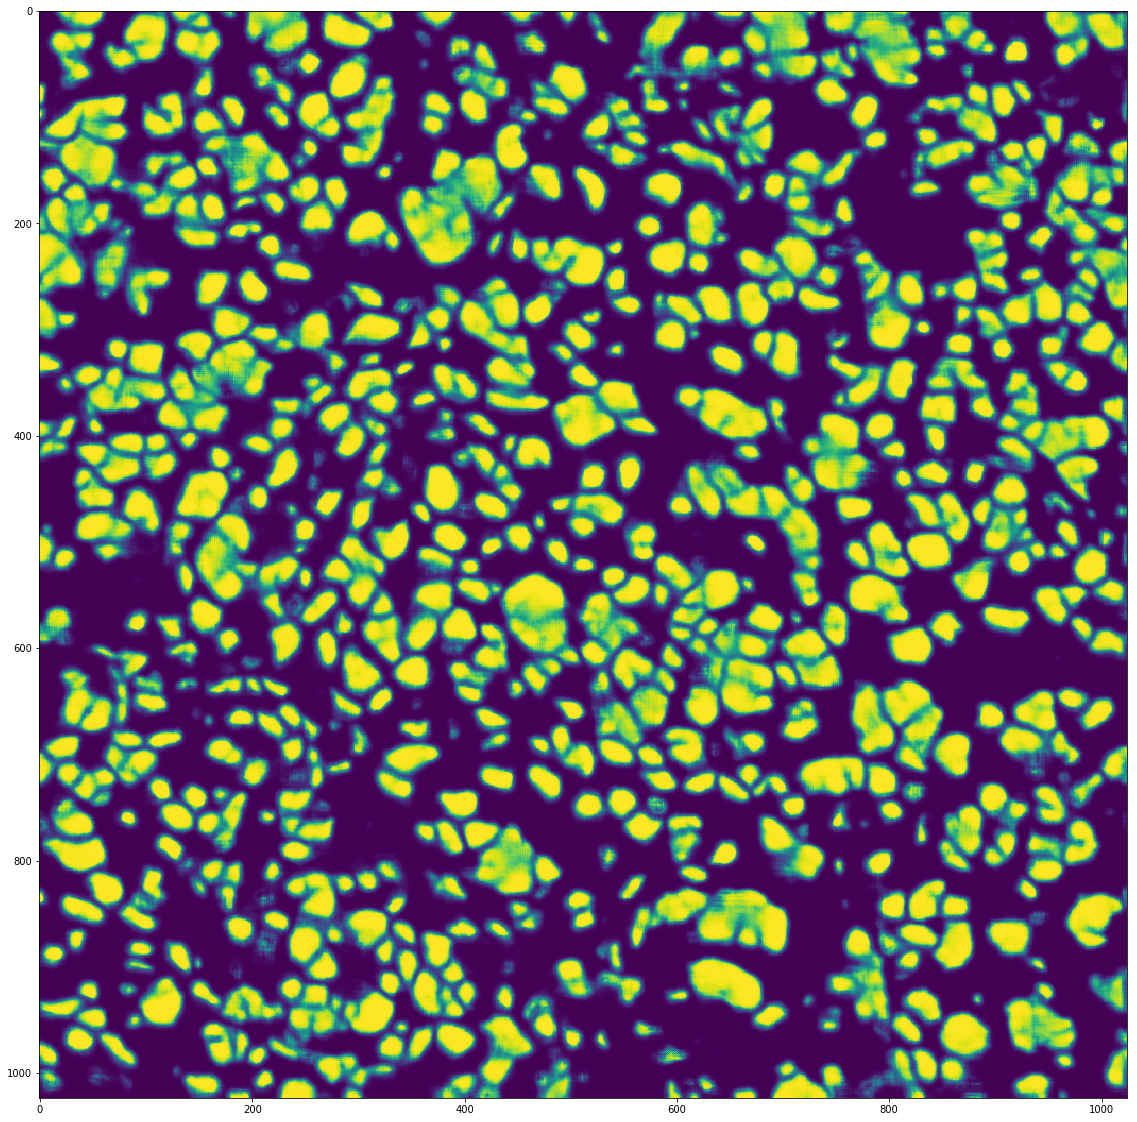

In [32]:
plt.figure(figsize = (20, 20))
plt.imshow(test_images[0, :, :, 1])

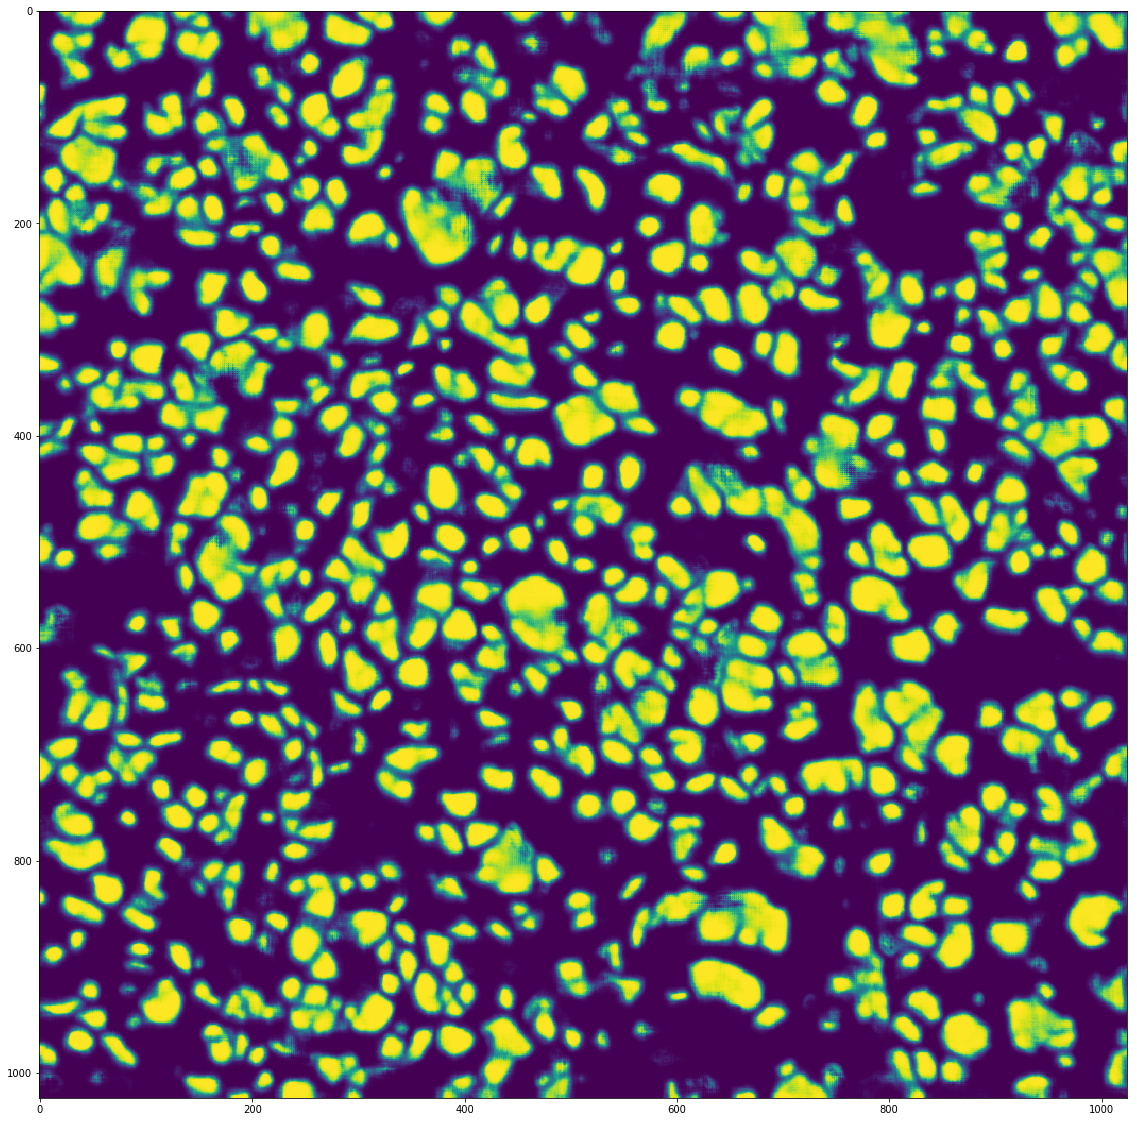

In [24]:
plt.figure(figsize = (20, 20))
plt.imshow(test_images[0, :, :, 1])

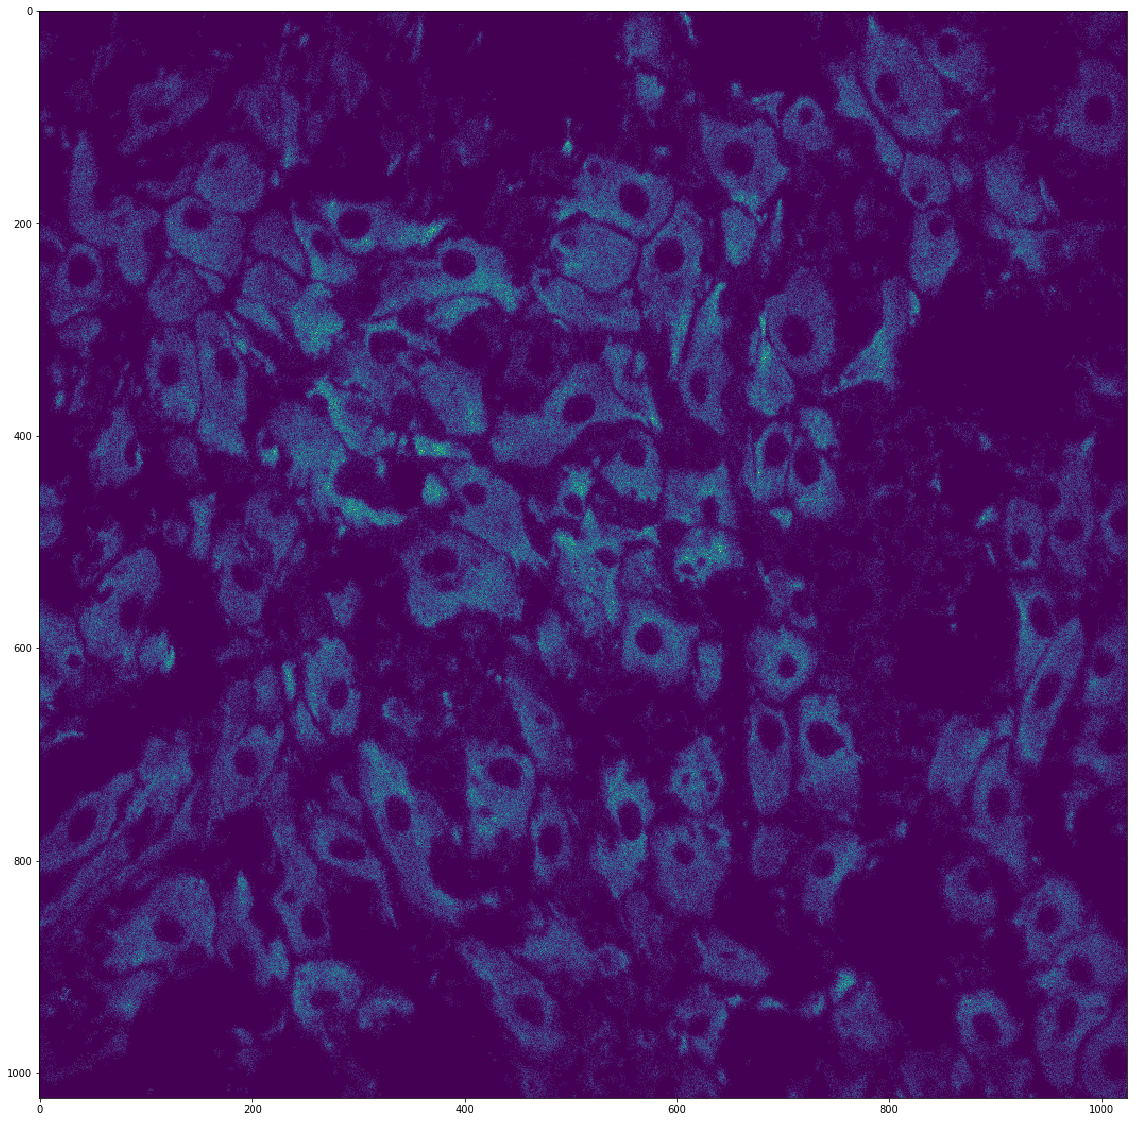

In [56]:
plt.figure(figsize = (20, 20))
plt.imshow(X_test[0, :, :, 5])